<a href="https://colab.research.google.com/github/EdwSanA/DPro_Tareas/blob/main/Regresion_logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

iter    0/3000  loss=0.69315  val_loss=0.62921
iter  300/3000  loss=0.14822  val_loss=0.24774
iter  600/3000  loss=0.13969  val_loss=0.24348
iter  900/3000  loss=0.13755  val_loss=0.24531
iter 1200/3000  loss=0.13682  val_loss=0.24729
iter 1500/3000  loss=0.13654  val_loss=0.24881
iter 1800/3000  loss=0.13642  val_loss=0.24991
iter 2100/3000  loss=0.13637  val_loss=0.25068
iter 2400/3000  loss=0.13634  val_loss=0.25121
iter 2700/3000  loss=0.13633  val_loss=0.25158

--- Métricas (Scratch Logistic) ---
Accuracy : 0.8800
Precision: 0.9091
Recall   : 0.8333
F1-score : 0.8696
Matriz de confusión:
 [[12  1]
 [ 2 10]]

--- Métricas (sklearn LogisticRegression) ---
Accuracy : 0.9600
Precision: 1.0000
Recall   : 0.9167
F1-score : 0.9565
Matriz de confusión:
 [[13  0]
 [ 1 11]]


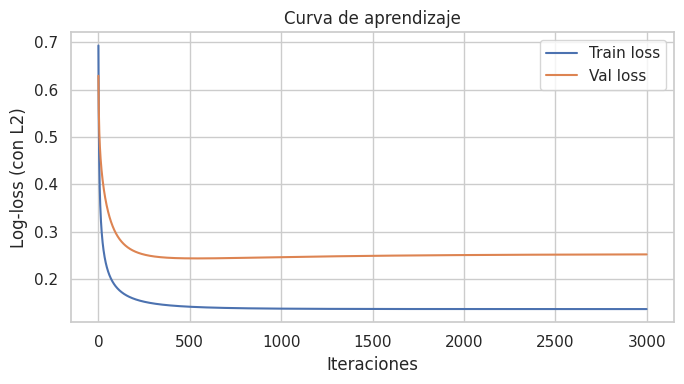

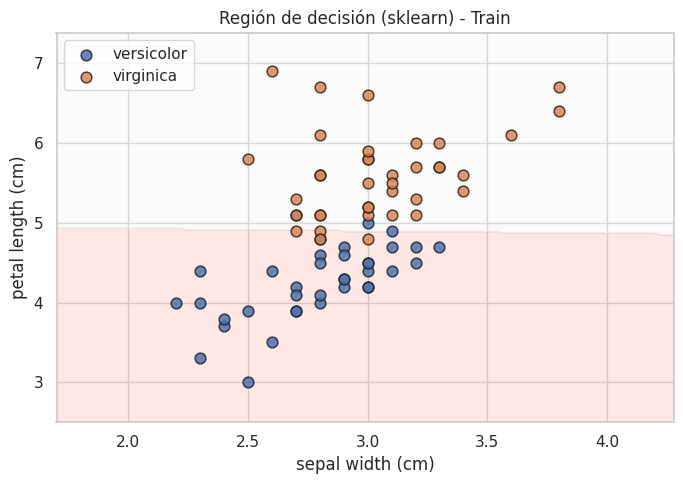

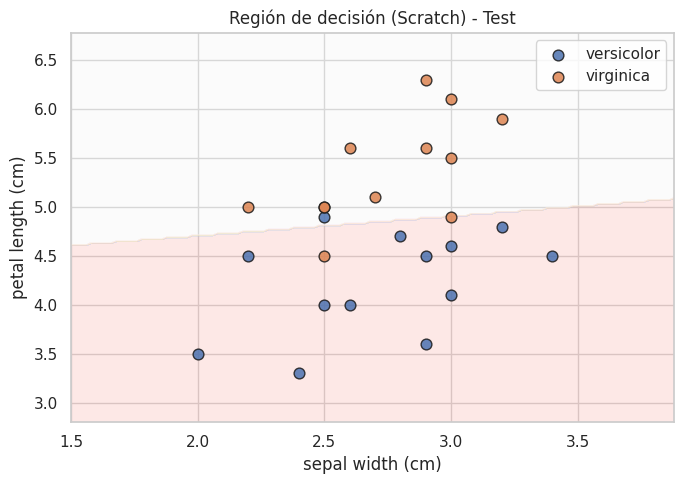

Pesos guardados en: scratch_logreg_weights.npz

--- Métricas (Scratch cargado) ---
Accuracy : 0.8800
Precision: 0.9091
Recall   : 0.8333
F1-score : 0.8696
Matriz de confusión:
 [[12  1]
 [ 2 10]]

Probabilidades (primeros 6): [1.    0.864 0.052 0.01  0.999 0.999]
Predicciones (primeros 6):    [1 1 0 0 1 1]


In [1]:
# ============================================================
# REGRESIÓN LOGÍSTICA DESDE CERO (Scratch) + comparación SKLEARN
# Dataset: Iris (versicolor vs virginica) con features:
#   - eje X: sepal width (cm)
#   - eje Y: petal length (cm)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
import pickle

sns.set(style="whitegrid", context="notebook")

# ------------------------------
# Clase: ScratchLogisticRegression
# ------------------------------
class ScratchLogisticRegression:
    def __init__(self, num_iter=3000, lr=0.5, bias=True, verbose=False, reg_lambda=0.01):
        """
        num_iter: número de iteraciones de gradiente
        lr: tasa de aprendizaje
        bias: True -> añade término de sesgo (intercepto)
        verbose: imprime progreso
        reg_lambda: regularización L2 (>=0)
        """
        self.iter = int(num_iter)
        self.lr = float(lr)
        self.bias = bool(bias)
        self.verbose = bool(verbose)
        self.reg_lambda = float(reg_lambda)
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        self.coef_ = None  # vector de parámetros (incluye bias si bias=True)

    @staticmethod
    def _sigmoid(z):
        z = np.clip(z, -500, 500)     # estabilidad numérica
        return 1.0 / (1.0 + np.exp(-z))

    def _linear_hypothesis(self, X):
        return np.dot(X, self.coef_)   # (n_samples, n_features) · (n_features,)

    def _compute_loss(self, h, y):
        m = y.shape[0]
        eps = 1e-15
        h = np.clip(h, eps, 1 - eps)
        # log-loss
        loss = -(1.0/m) * np.sum(y*np.log(h) + (1-y)*np.log(1-h))
        # regularización L2 (sin intercepto)
        if self.reg_lambda > 0:
            if self.bias:
                theta = self.coef_.copy()
                theta[0] = 0.0
                loss += (self.reg_lambda/(2.0*m)) * np.sum(theta**2)
            else:
                loss += (self.reg_lambda/(2.0*m)) * np.sum(self.coef_**2)
        return loss

    def _gradient_descent(self, X, h, y):
        m = X.shape[0]
        grad = (1.0/m) * (X.T @ (h - y))
        if self.reg_lambda > 0:
            if self.bias:
                theta = self.coef_.copy()
                theta[0] = 0.0
                grad += (self.reg_lambda/m) * theta
            else:
                grad += (self.reg_lambda/m) * self.coef_
        self.coef_ -= self.lr * grad

    def fit(self, X, y, X_val=None, y_val=None):
        X = np.asarray(X);  y = np.asarray(y).reshape(-1)
        if self.bias:
            X_tr = np.hstack([np.ones((X.shape[0], 1)), X])
            if X_val is not None:
                X_val = np.asarray(X_val)
                X_val = np.hstack([np.ones((X_val.shape[0], 1)), X_val])
        else:
            X_tr = X

        self.coef_ = np.zeros(X_tr.shape[1])

        for i in range(self.iter):
            z = self._linear_hypothesis(X_tr)
            h = self._sigmoid(z)
            self.loss[i] = self._compute_loss(h, y)
            self._gradient_descent(X_tr, h, y)

            if X_val is not None and y_val is not None:
                z_val = self._linear_hypothesis(X_val)
                h_val = self._sigmoid(z_val)
                self.val_loss[i] = self._compute_loss(h_val, y_val)

            if self.verbose and (i % max(1, self.iter//10) == 0):
                msg = f"iter {i:4d}/{self.iter}  loss={self.loss[i]:.5f}"
                if X_val is not None and y_val is not None:
                    msg += f"  val_loss={self.val_loss[i]:.5f}"
                print(msg)

    def predict_proba(self, X):
        X = np.asarray(X)
        Xp = np.hstack([np.ones((X.shape[0], 1)), X]) if self.bias else X
        return self._sigmoid(self._linear_hypothesis(Xp))

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

    # Guardar / Cargar pesos (opcional para el Problema 8)
    def save_weights(self, path_prefix="scratch_logreg_weights"):
        npz_path = f"{path_prefix}.npz"
        np.savez(npz_path, coef=self.coef_, iter=self.iter, lr=self.lr,
                 reg_lambda=self.reg_lambda, bias=self.bias)
        with open(f"{path_prefix}.pkl", "wb") as f:
            pickle.dump({
                "coef": self.coef_, "iter": self.iter, "lr": self.lr,
                "reg_lambda": self.reg_lambda, "bias": self.bias
            }, f)
        return npz_path

    def load_weights(self, npz_path):
        d = np.load(npz_path)
        self.coef_ = d["coef"]
        for k in ("iter", "lr", "reg_lambda", "bias"):
            if k in d.files: setattr(self, k, d[k].item())

# ------------------------------
# Utilidades
# ------------------------------
def print_metrics(y_true, y_pred, labels=("versicolor","virginica")):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("Matriz de confusión:\n", cm)

def decision_region_plot(X, y, model, scaler=None, title="Decision region",
                         step=0.02, target_names=("versicolor","virginica"),
                         xlabel="sepal width (cm)", ylabel="petal length (cm)"):
    assert X.shape[1] == 2, "Se requieren exactamente 2 características."
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))
    mesh = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(scaler.transform(mesh) if scaler is not None else mesh)
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(7,5))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="Pastel1")
    for lab in np.unique(y):
        plt.scatter(X[y==lab,0], X[y==lab,1], s=60, edgecolor="k",
                    label=target_names[lab], alpha=0.85)
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

# ------------------------------
# Datos: Iris (versicolor vs virginica)
# Features: sepal width (1) y petal length (2)
# ------------------------------
iris = datasets.load_iris()
X_all = iris.data
y_all = iris.target

mask = (y_all==1) | (y_all==2)          # versicolor y virginica
X = X_all[mask][:, [1, 2]]              # sepal width, petal length
y = (y_all[mask] == 2).astype(int)      # versicolor->0, virginica->1

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# estandarización (útil para GD)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# ------------------------------
# Entrenar modelo Scratch
# ------------------------------
scratch = ScratchLogisticRegression(
    num_iter=3000, lr=0.5, bias=True, verbose=True, reg_lambda=0.01
)
scratch.fit(X_train_sc, y_train, X_val=X_test_sc, y_val=y_test)

# Predicciones y métricas (Scratch)
y_pred_scratch = scratch.predict(X_test_sc)
print("\n--- Métricas (Scratch Logistic) ---")
print_metrics(y_test, y_pred_scratch)

# ------------------------------
# Comparación con sklearn
# ------------------------------
sklog = LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=1000)
sklog.fit(X_train_sc, y_train)
y_pred_sk = sklog.predict(X_test_sc)
print("\n--- Métricas (sklearn LogisticRegression) ---")
print_metrics(y_test, y_pred_sk)

# ------------------------------
# Curvas de aprendizaje (log-loss)
# ------------------------------
plt.figure(figsize=(7,4))
plt.plot(np.arange(scratch.iter), scratch.loss, label="Train loss")
if np.any(scratch.val_loss):
    plt.plot(np.arange(scratch.iter), scratch.val_loss, label="Val loss")
plt.xlabel("Iteraciones"); plt.ylabel("Log-loss (con L2)")
plt.title("Curva de aprendizaje"); plt.legend(); plt.tight_layout(); plt.show()

# ------------------------------
# Regiones de decisión
# ------------------------------
decision_region_plot(X_train, y_train, model=sklog, scaler=scaler,
                     title="Región de decisión (sklearn) - Train")
decision_region_plot(X_test, y_test, model=scratch, scaler=scaler,
                     title="Región de decisión (Scratch) - Test")

# ------------------------------
# Guardar y cargar pesos (opcional – Problema 8)
# ------------------------------
npz_path = scratch.save_weights("scratch_logreg_weights")
print(f"Pesos guardados en: {npz_path}")

scratch_loaded = ScratchLogisticRegression()
scratch_loaded.load_weights(npz_path)
y_loaded = scratch_loaded.predict(X_test_sc)
print("\n--- Métricas (Scratch cargado) ---")
print_metrics(y_test, y_loaded)

# Probabilidades de ejemplo
print("\nProbabilidades (primeros 6):", np.round(scratch.predict_proba(X_test_sc)[:6], 3))
print("Predicciones (primeros 6):   ", scratch.predict(X_test_sc)[:6])
